<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

<!--BADGES-->
<a href="../slides/27.00-Cenario_Rio_apresentacao.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/local-slides-darkgreen" alt="localslides" title="Local Slides"></a>
&nbsp;

<!--NAVIGATOR-->
[<- O cenário da cidade do Rio de Janeiro: primeiras simulações](26.00-Cenario_Rio_primeiras_simulacoes.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) 

---


# Modelo individual estocástico em tempos discretos adaptado ao município do Rio de Janeiro

**Objetivos:**

- Apresentar o modelo individual estocástico em tempos discretos utilizado por grupos como **Imperial/Pitt**, **UW/LANL** e **VBI**.

- Discutir as adaptações feitas para o Rio de Janeiro.

- Exibir algumas simulações.

In [1]:
import datetime # date and time tools

import os, sys

import math

import random

import numpy as np
from scipy import stats
import pandas as pd

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [2]:
def show_video(path_to_video, width):
    video = io.open((path_to_video), 'r+b').read()
    encoded = base64.b64encode(video)
    video_data = '''<video width="{0}" alt="test" controls><source src="data:video/mp4;base64,{1}" type="video/mp4" />
                    </video>'''.format(width, encoded.decode('ascii'))
    return HTML(data=video_data)

In [3]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import episiming

In [4]:
sns.set_style("darkgrid")

In [5]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 11/Jun/2020


## Equipe

- Professores (IM/UFRJ):
    - Amaury Alvarez Cruz (DCC)
    - Bernardo Freitas Paulo da Costa (DMA)
    - Heudson Mirandola (DM)
    - Ricardo Martins da Silva Rosa (DMA)
- Alunos de Mestrado (Matemática - IM/UFRJ):
    - Thiago Holleben
- Alunos de Graduação (Matemática Aplicada - IM/UFRJ):
    - Beatriz Farah
    - Cynthia Herkenhoff
    - Gil Sales Miranda Neto
    - Rodrigo Peregrino 

## Modelos baseados em indivíduos e o relatório do Imperial Colege

- O [Relatório do Imperial College de 16 de março](#Referências) influenciou ações políticas no Reino Unido e no mundo.

- Produzido pelo **Grupo de Resposta sobre o COVID-19 do Imperial College** *(Imperial College COVID-19 Response Team)*.

- Apresenta resultados da modelagem epidemiológica incluindo intervenções não-farmaceuticas (e.g. sem vacinação), como **distanciamento social** e **quarentena**.

- Modelos do tipo **individual, estocástico, espacialmente estruturado e com evolução temporal discreta**.

- Modelo usado por diversos grupos em um estudo após a epidemia de SARS (2002-2004):

    - Imperial College and the University of Pittsburgh **(Imperial/Pitt)**.

    - University of Washington and Fred Hutchinson Cancer Research Center in Seattle and the Los Alamos National Laboratories **(UW/LANL)**.

    - Virginia Bioinformatics Institute of the Virginia Polytechnical Institute and State University **(VBI)**.

## A importância da estrutura da rede de conexões

- A figura a seguir, retirada do livro [Kiss, Miller & Simon (2017)](#Referências), mostra a importância da estrutura da rede conexões na evolução da epidemia.

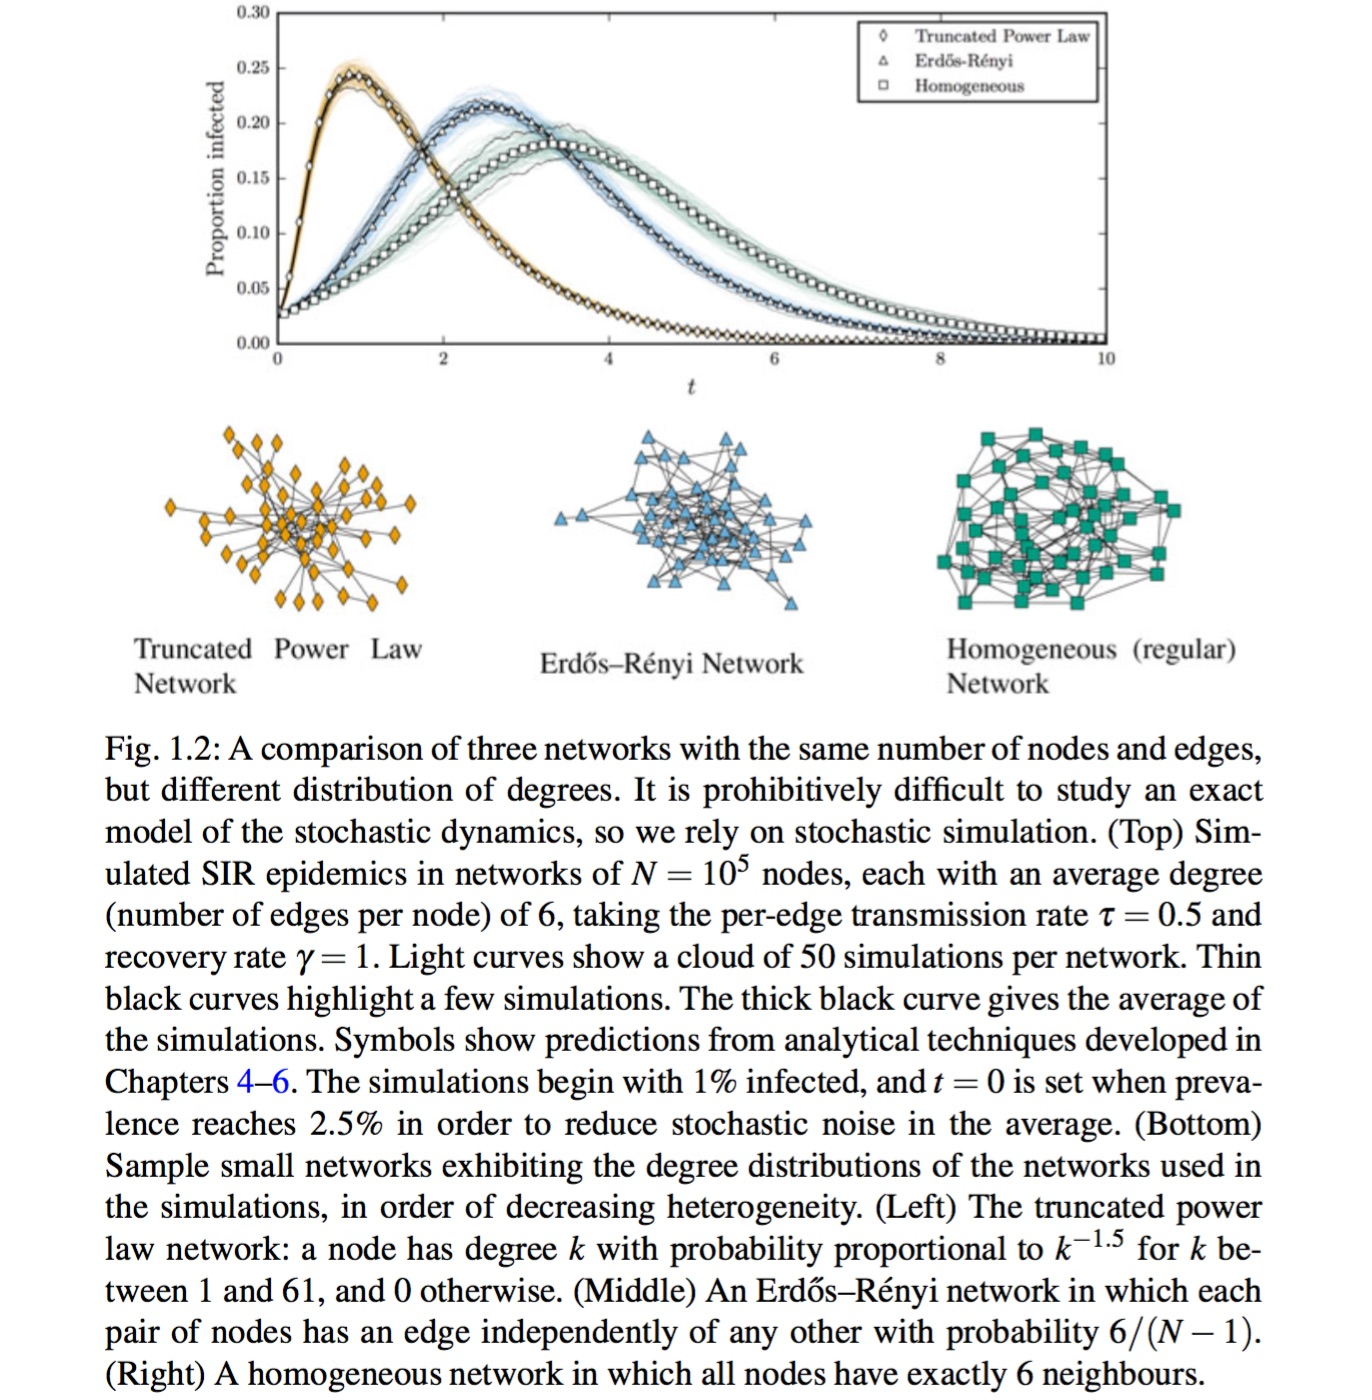

In [6]:
Image(filename=os.path.join('..', 'input', 'networks', 'SIR_on_different_networks.jpg'), width=800)

## Estrutura do modelo

- O modelo é **heterogêno**, considerando particularidades de **cada indivíduo** e de cada área da região.

- Cada indivíduo está associada a diversas **redes de interação:**

    - residências
    - escolas de diferentes níveis
    - trabalho
    - encontros aleatórios com a população em geral
    - etc.

- O modelo evolui de maneira **probabilística** e em **tempos discretos** (e.g. 6 horas, 12 horas, 1 dia, etc.).

## Exemplo: simulação de epidemia na Tailândia

- A seguir, dois vídeos retirados das [informações suplementares](https://www.nature.com/articles/nature04017?draft=collection#Sec14) do artigo de [Ferguson et al. (2005)](#Referência), sobre **estratégias para conter pandemias de influenza na sudeste asiático**. 

- Observem que eles já estavam pensando nesses estratégias!

- Vieram motivadas pela epidemia de SARS que apareceu no final de 2002 e só foi considerada contida em meados de 2003, com vários casos ocorrendo até o iníco de 2004.

- Simulação com **85 milhões de indivíduos**!

- A primeira, **sem estratégia** de contenção da epidemia.

- A segunda, **com estratégia, bem sucedida**.

### Sem estratégia

- $R_0=1.5$.

- Video mostra 100 dias de evolução.

- Cores:

    - Cinza: densidade de suscetíveis em escala logarítmica
    - Vermelho: áreas infectadas
    - Verde: áreas recuperadas
    - Azul: áreas em tratamento

In [7]:
show_video(os.path.join('..', 'input', 'networks', '41586_2005_BFnature04017_MOESM2_ESM.mp4'), '50%')

#### Estratégia bem sucedida

- $R_0=1.8$;

- Estratégia implementada na Tailândia e em parte dos países vizinhaça, dentro de um raio de 100km da Tailândia.

- Distanciamento social

- Quarentena de casos detectados

- Profilaxia em um raio de 5km radial de casos dectados

- Fechamento de 90% de escolas e de 50% dos lugares de trabalho, em um raio de 5km.

- Video mostra 300 dias de evolução.

- Cores:

    - Cinza: densidade de suscetíveis em escala logarítmica
    - Vermelho: áreas infectadas
    - Verde: áreas recuperadas
    - Azul: áreas em tratamento

In [8]:
show_video(os.path.join('..', 'input', 'networks', '41586_2005_BFnature04017_MOESM3_ESM.mp4'), '80%')

## Detalhes do modelo

- Há duas partes que devemos considerar:

    - Os diferentes **estágios da infecção** (suscetível, exposto, contagioso, recuperado, etc.)
    
    - Os diferentes **locais de contágio** (na residência, na escola, no trabalho, na rua, etc.)
    
- Os diferentes grupos (**Imperial/Pitt**, **UW/LANL**, **VBI**) tratam essas partes de maneiras ligeiramente diferentes:

    - Em relação às **redes de contato**:

| rede | Imperial | UW | VBI |
| --- | --- | --- | --- |
| Home | + | + | + |
| Work | + | + | + |
| School | + | + | + |
| Day care |  | + |  |
| Play group |  | + |  |
| College |  |  | + |
| Shopping |  |  | + |
| Neighborhood |  | + |  |
| Neighborhood clusters |  | + |  |
| Other/Community | + |  | + |


### Sobre os estágios da infecção

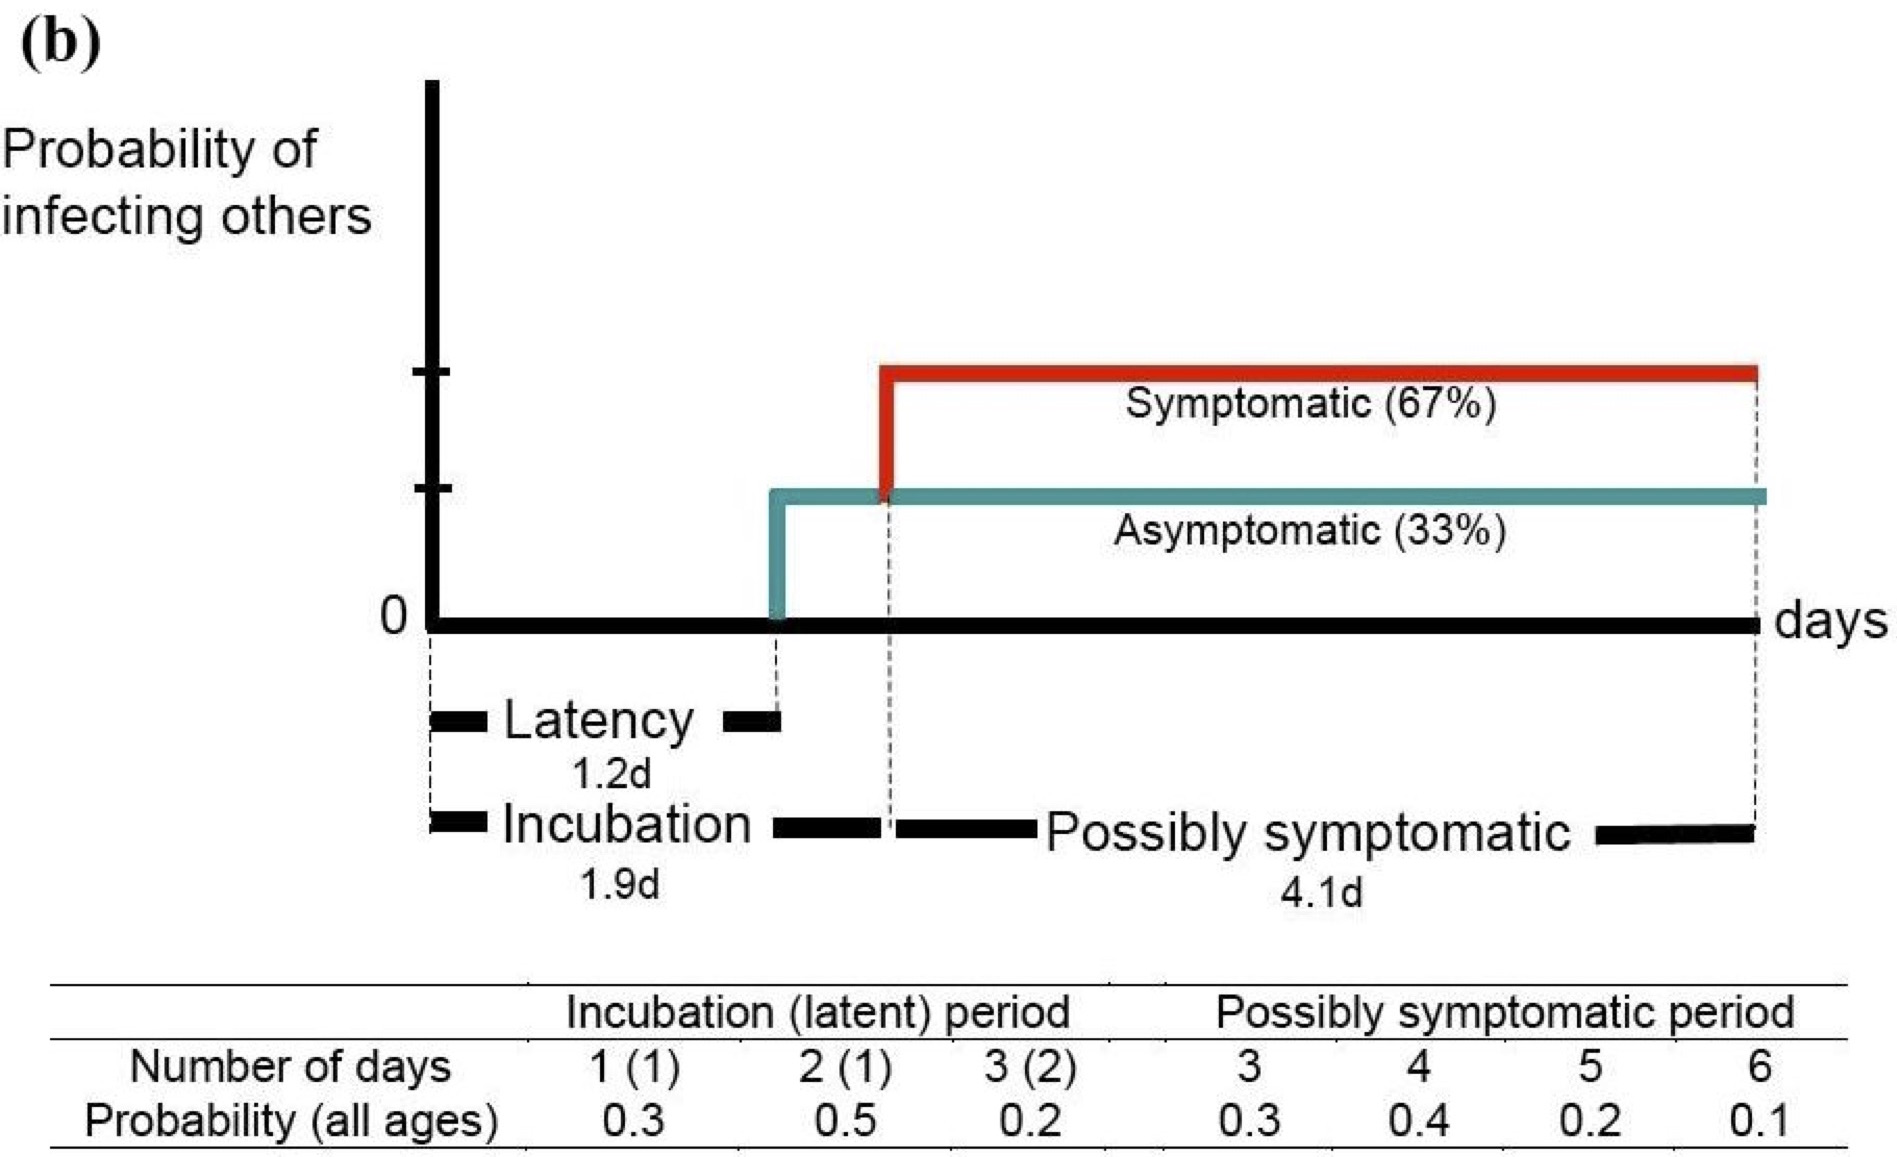

In [9]:
Image(filename=os.path.join('..', 'input', 'modelos_individuais',
                            'Germann_SupportingText_01266Fig3b.jpg'), width=800)

### Sobre o período de incubação e a força de contágio durante a infecção

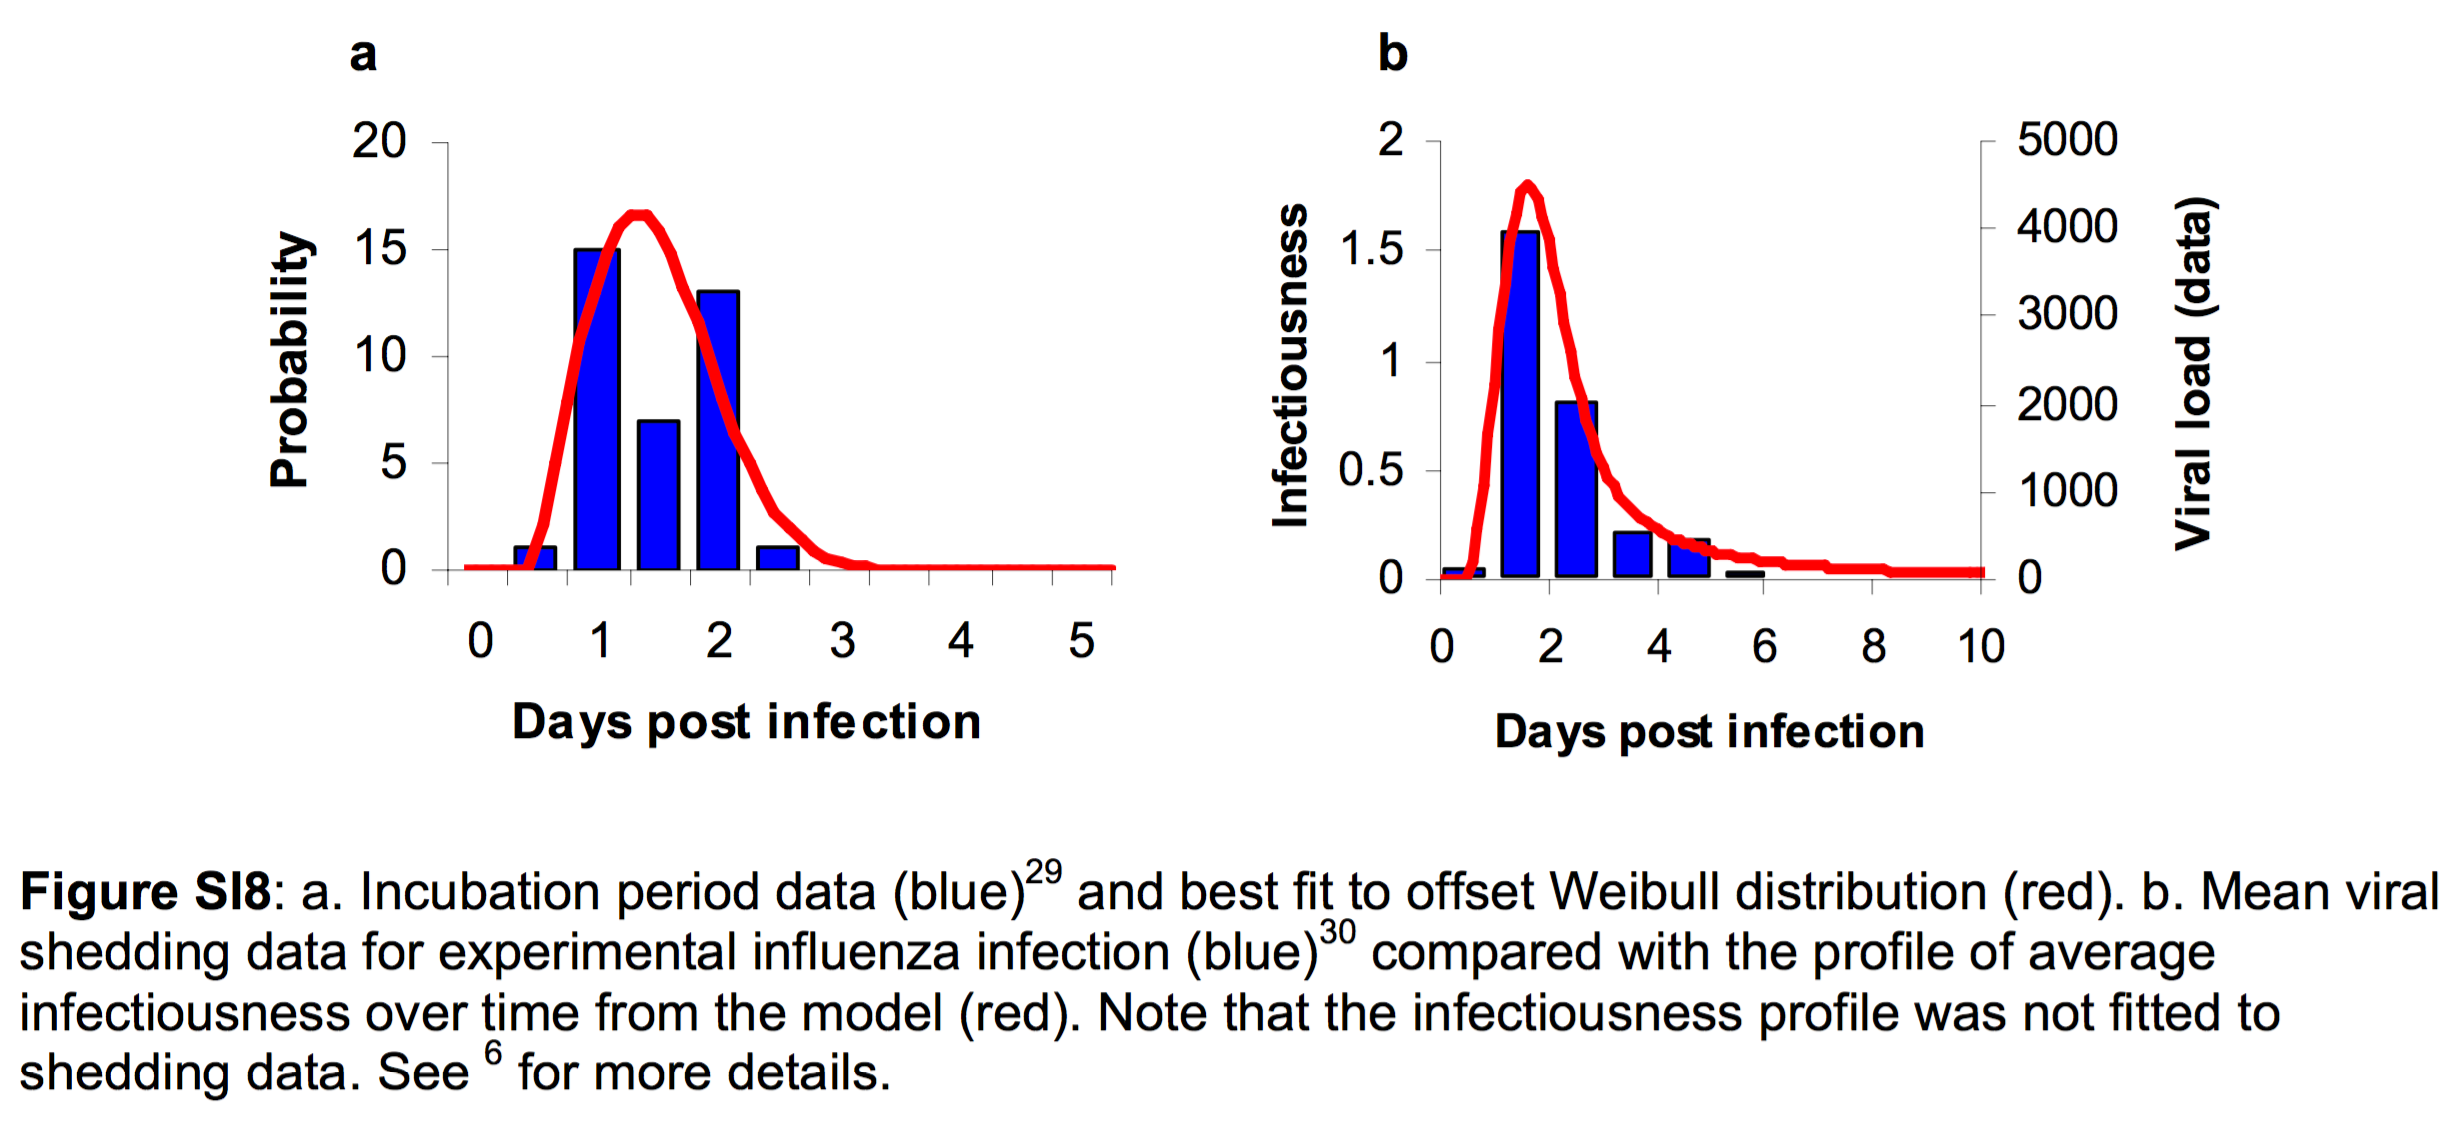

In [10]:
Image(filename=os.path.join('..', 'input', 'modelos_individuais',
                            '41586_2006_BFnature04795_MOESM28_ESM_FigureS18.png'), width=800)

## Parâmetros e dinâmica do modelo

- Há um índice $i$ representando **cada indivíduo** da população.

- Há um determinado número de **residências** onde os indivíduos habitam

- Há diferentes tipos de **locais de interação**, como escolas e trabalhos

- Cada **indivíduo** tem associado

    - a sua **idade**
    
    - a sua **residência**

    - o seu **local de estudo/trabalho**
    
    - o seu **estágio** no processo de infecção.
    
    - o **grau da infecção**
    
    - o **instante em que foi infectado**
    
    - uma modulação em sua **suscetibilidade** a ser infectado
    
    - a sua **força de contágio**

### Força de infecção

A **força de infecção** $\lambda_i$ de cada indivíduo é dada por

$$ 
  \begin{align*}
    \lambda_i & = \frac{1}{n_i^\alpha}\sum_{k; h_k = h_i}  I_k \beta_h\kappa(t-\tau_k)\rho_k(1 + C_k (\omega-1)) \quad \textrm{(na residência)} \\
    & \quad + \sum_{j, k; l_k^j = l_i^j} \frac{I_k \beta_p^j\kappa(t-\tau_k)\rho_k(1 + C_k(\omega\psi_p^j(t-\tau_\kappa)-1)}{m_i^j} \quad \textrm{(na local de escola/trabalho)} \\
    & \quad + \frac{\sum_k I_k\zeta(a_i)\beta_c\kappa(t-\tau_k)f(d_{ik})\rho_k(1 + C_k (\omega-1))}{\sum_l f(d_{il})} \quad \textrm{(global)},
  \end{align*}
$$

onde

- $i, k$ são índices de indivíduos;

- $j$ é um índice de local;

- $\beta_h$, $\beta_p^j$ e $\beta_c$ são coeficientes de transmissão em **residências**, **locais de trabalho/escola** e em toda a região (rede **global**);

- $\alpha=0.8$ é uma potência para escalonar em função do tamanho da residência;

- $\omega=2$ é um fator de contágio para infecções severas, em relação a não-severas.

- $\kappa=\kappa(s)$ é uma função temporal modulando a força de infecção

- $\psi_p^j = \psi_p^j(s) = 0.1, 0.2, 0.25, 0.5$, para $j=1,2,3,4$ e $s>0.25 \;\texttt{dias}$, e $\psi_p^j=0$, caso contrário, são os fatores de taxa de contato, em cada tipo de local, para infecções severas, como função do tempo $s=t-\tau$ desde o início do contágio, **refletindo ao grau de ausência do indivíduo no local.**

- $f(d_{ik})$ é o núcleo de distância e $d_{ik}$ é a distância euclidiana entre os indivíduos $i$ e $k$.

- $\zeta(a_i)$ é a taxa relativa de contato em relação à mobilidade de um indivíduo com idade $a_i$.

- $\rho_k = 1$ é a taxa relativa de infecção do indivíduo $k$. (Mais geralmente $\rho_k$ pode ser dado por uma distribuição gama com média $1$ e fator de forma $\alpha=0.2$.)

## Montando um cenário reduzido do Rio de Janeiro

In [11]:
tx_reducao = 100
cenario_rio = episiming.cenarios.RiodeJaneiro(tx_reducao)
print(f'População do cenário reduzido: {cenario_rio.num_pop}\n')

População do cenário reduzido: 67973



## Visualizando o cenário

### Visualizando a população

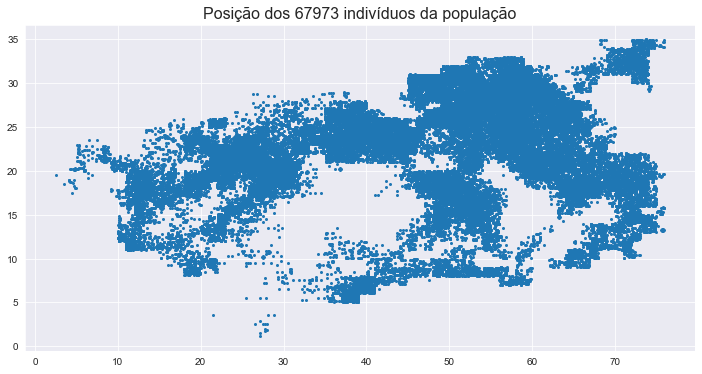

In [12]:
x, y = cenario_rio.pop_posicoes.T
plt.figure(figsize=(12,6))
plt.scatter(x, y, s=4)
plt.title(f'Posição dos {cenario_rio.num_pop} indivíduos da população', fontsize=16)
plt.show()

### Pirâmide etária

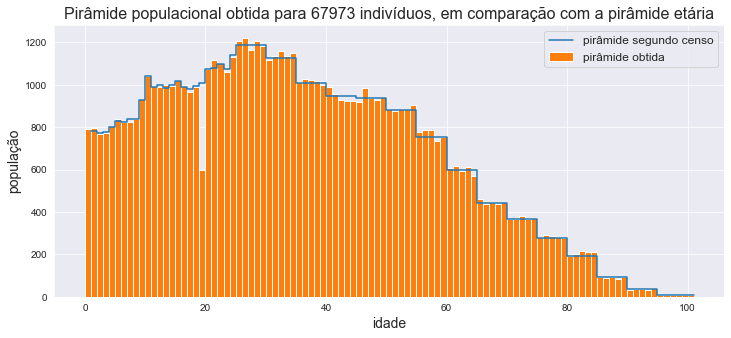

In [13]:
plt.figure(figsize=(12,5))
plt.hist(cenario_rio.pop_idades, bins = list(range(cenario_rio.idade_max+1)), color='tab:orange', label='pirâmide obtida')
plt.step(list(range(1, cenario_rio.idade_max+1)), cenario_rio.num_pop*cenario_rio.idades_fracoes, label='pirâmide segundo censo')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title(f'Pirâmide populacional obtida para {cenario_rio.num_pop} indivíduos, em comparação com a pirâmide etária', fontsize=16)
plt.legend(fontsize=12)
plt.show()

### Distribuição das escolas municipais

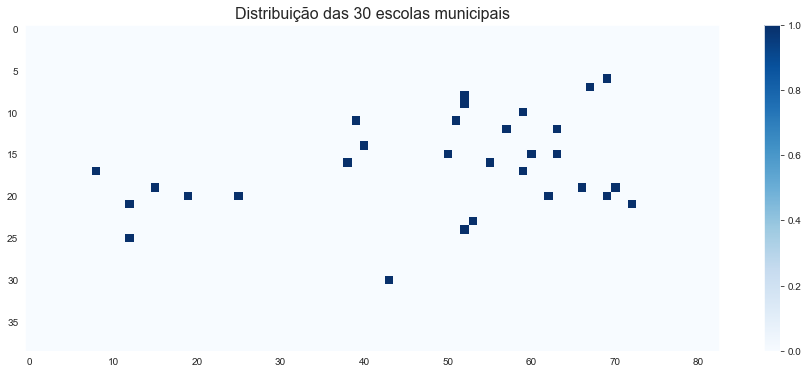

In [14]:
plt.figure(figsize=(16,6))
plt.imshow(cenario_rio.dist_escolas, cmap='Blues', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {int(cenario_rio.dist_escolas.sum())} escolas municipais', fontsize=16)
plt.show()

### Posição dos alunos

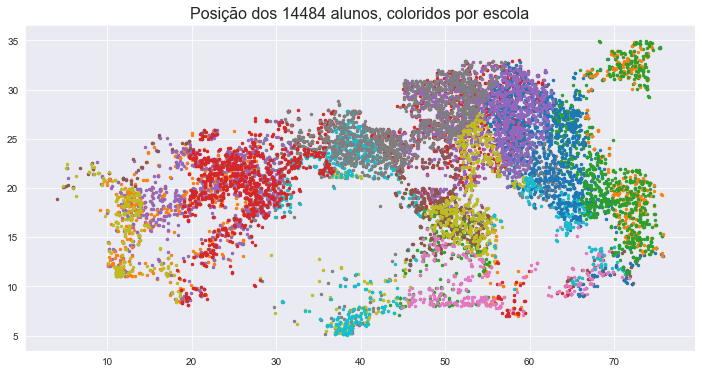

In [15]:
plt.figure(figsize=(12,6))
n = 0
for escola in cenario_rio.escolas:
    x, y = cenario_rio.pop_posicoes[escola].T
    plt.scatter(x, y, s=6)
    n += len(escola)
    
plt.title(f'Posição dos {n} alunos, coloridos por escola', fontsize=16)
plt.show()

### Distribuição dos locais de trabalho

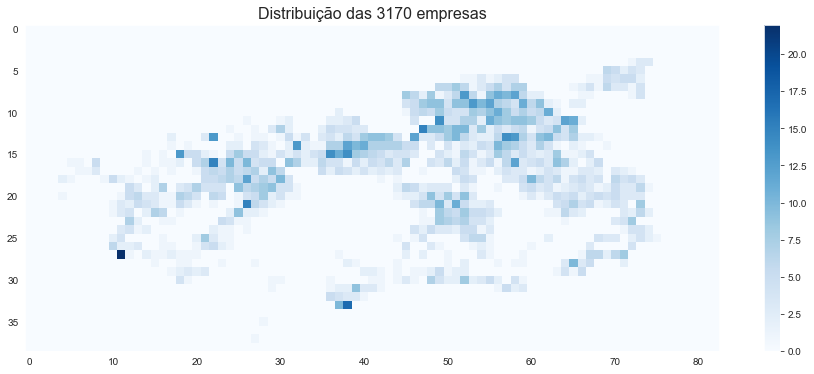

In [16]:
plt.figure(figsize=(16,6))
plt.imshow(cenario_rio.emp_por_bloco, cmap='Blues', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {cenario_rio.emp_por_bloco.sum()} empresas', fontsize=16)
plt.show()

### Posição dos indivíduos alocados nas empresas

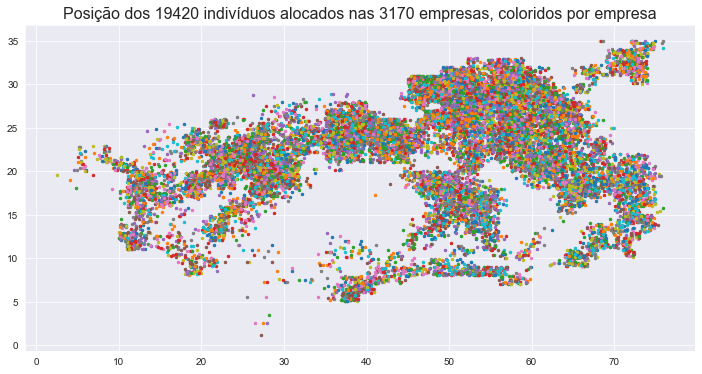

In [17]:
plt.figure(figsize=(12,6))
n = 0
for membros in cenario_rio.emp_membros:
    x, y = cenario_rio.pop_posicoes[membros].T
    plt.scatter(x, y, s=6)
    n += len(membros)
    
plt.title(f'Posição dos {n} indivíduos alocados nas {cenario_rio.emp_por_bloco.sum()} empresas, '
          + 'coloridos por empresa', fontsize=16)
plt.show()

## Redes

### Rede residencial

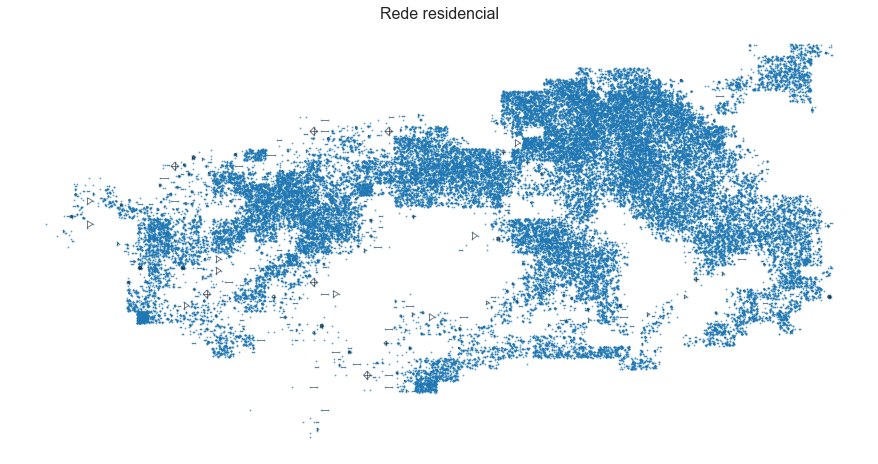

In [18]:
plt.figure(figsize=(12,6))
nx.draw(cenario_rio.G_r, pos=cenario_rio.attr_pos, node_size=1, alpha=0.5)
plt.title('Rede residencial', fontsize=16)
plt.show()

### Rede da primeira escola da lista

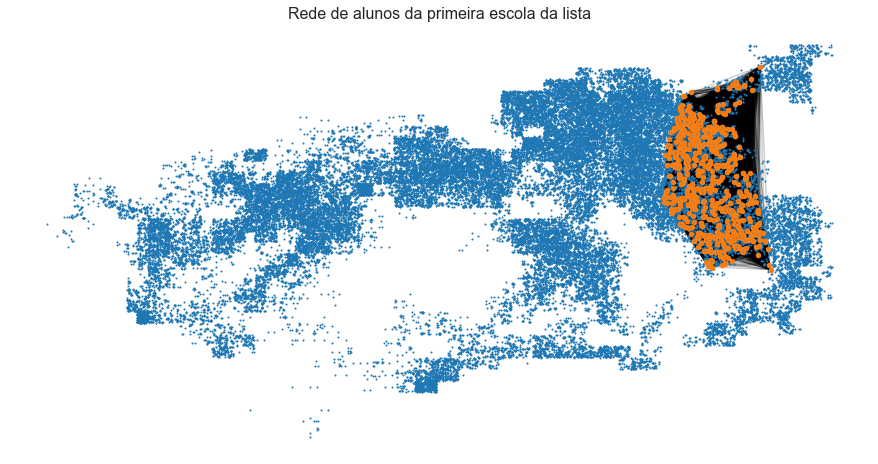

In [19]:
j = 0
plt.figure(figsize=(12,6))
nx.draw(cenario_rio.G_esc.subgraph(tuple(cenario_rio.escolas[j])),
        pos=cenario_rio.attr_pos, node_size=1, alpha=0.1)
x, y = cenario_rio.pop_posicoes.T
plt.scatter(x, y, color='tab:blue', s=1)
x_s, y_s = cenario_rio.pop_posicoes[cenario_rio.escolas[j]].T
plt.scatter(x_s, y_s, color = 'tab:orange', s=20)
plt.title('Rede de alunos da primeira escola da lista', fontsize=16)
plt.show()

### Rede da última empresa da lista

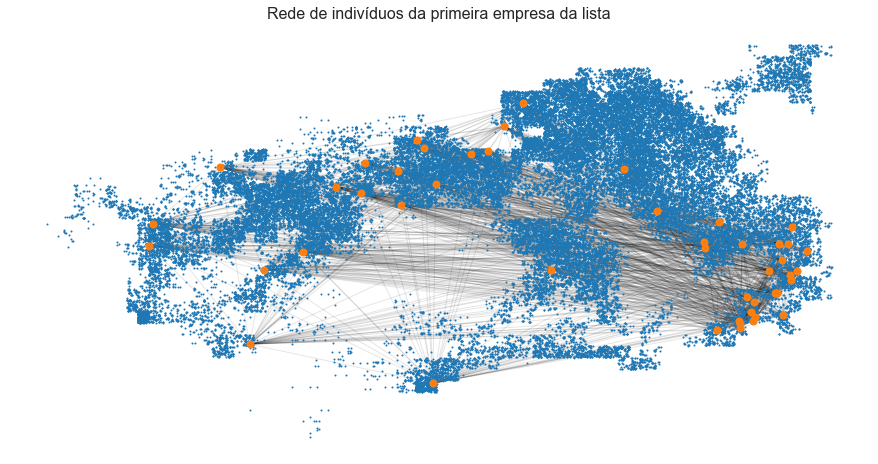

In [20]:
j = -1
plt.figure(figsize=(12,6))
nx.draw(cenario_rio.G_emp.subgraph(tuple(cenario_rio.emp_membros[j])),
        pos=cenario_rio.attr_pos, node_size=1, alpha=0.1)
x, y = cenario_rio.pop_posicoes.T
plt.scatter(x, y, color='tab:blue', s=1)
x_e, y_e = cenario_rio.pop_posicoes[cenario_rio.emp_membros[j]].T
plt.scatter(x_e, y_e, color = 'tab:orange', s=50)
plt.title('Rede de indivíduos da primeira empresa da lista', fontsize=16)
plt.show()

## Simulações

### Montando um cenário mais reduzido do Rio de Janeiro

In [21]:
tx_reducao = 1000
cenario_rio = episiming.cenarios.RiodeJaneiro(tx_reducao)
print(f'População do cenário reduzido: {cenario_rio.num_pop}\n')

População do cenário reduzido: 6333



### Dados temporais para as simulações

In [22]:
dt = 1 # passo de tempo
t_0 = 0 # instante initial
num_dt = 80 # número de passos
dados_temporais = [t_0, dt, num_dt] # instantes de tempo

### Parâmetros de base

In [23]:
num_infectados_0_base = 20 # número inicial de infectados
beta_r_base = 0.5 # taxa de contágio nas residências
beta_esc_base = 0.4 # taxa de contágio nas escolas
beta_emp_base = 0.2 # taxa de contágio no trabalho
beta_c_base = 0.2 # taxa de contágio na comunidade
gamma_base = 0.1 # inverso do tempo de recuperação

### Simulação com os parâmetros de base

In [24]:
num_infectados_0 = num_infectados_0_base
beta_r = beta_r_base
beta_esc = beta_esc_base
beta_emp = beta_emp_base
beta_c = beta_c_base
gamma = gamma_base

cenario_rio.inicializa_infeccao(num_infectados_0, beta_r, beta_esc, beta_emp, beta_c,
                                gamma)

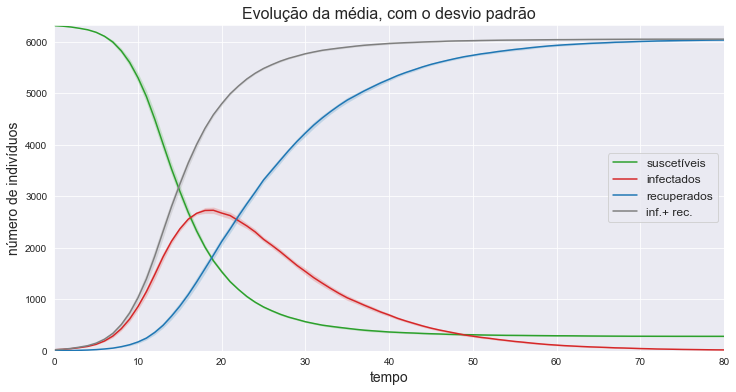

In [25]:
num_sim = 5 # número de simulações
X = cenario_rio.evolui_jit(dados_temporais, num_sim, show='sd')

### Simulação com parâmetros anulando contato nas escolas

In [26]:
num_infectados_0 = num_infectados_0_base
beta_r = beta_r_base
beta_esc = 0*beta_esc_base
beta_emp = beta_emp_base
beta_c = 0.8*beta_c_base
gamma = gamma_base

cenario_rio.inicializa_infeccao(num_infectados_0, beta_r, beta_esc, beta_emp, beta_c, gamma)

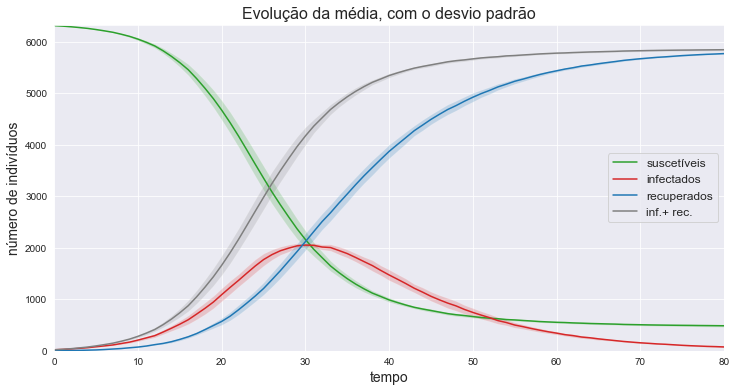

In [27]:
num_sim = 5 # número de simulações
X_esc_0 = cenario_rio.evolui_jit(dados_temporais, num_sim, show='sd')

### Simulação com parâmetros diminuindo contato nas empresas e comércio

In [28]:
num_infectados_0 = num_infectados_0_base
beta_r = beta_r_base
beta_esc = beta_esc_base
beta_emp = 0.5*beta_emp_base
beta_c = 0.5*beta_c_base
gamma = gamma_base

cenario_rio.inicializa_infeccao(num_infectados_0, beta_r, beta_esc, beta_emp, beta_c, gamma)

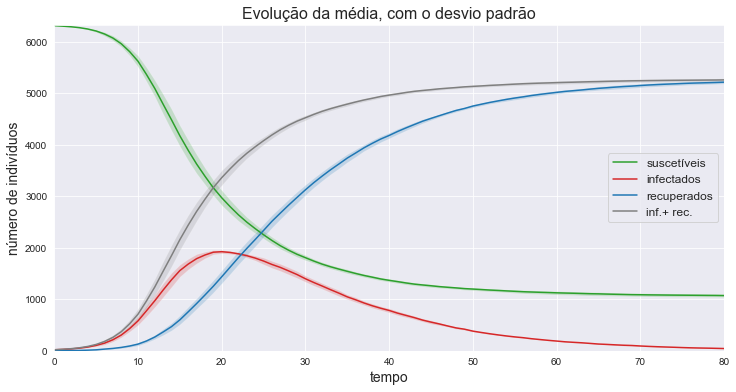

In [29]:
num_sim = 5 # número de simulações
X_ec = cenario_rio.evolui_jit(dados_temporais, num_sim, show='sd')

### Simulação com parâmetros diminuindo contatos em geral

In [30]:
num_infectados_0 = num_infectados_0_base
beta_r = beta_r_base
beta_esc = 0*beta_esc_base
beta_emp = 0.4*beta_emp_base
beta_c = 0.4*beta_c_base
gamma = gamma_base

cenario_rio.inicializa_infeccao(num_infectados_0, beta_r, beta_esc, beta_emp, beta_c, gamma)

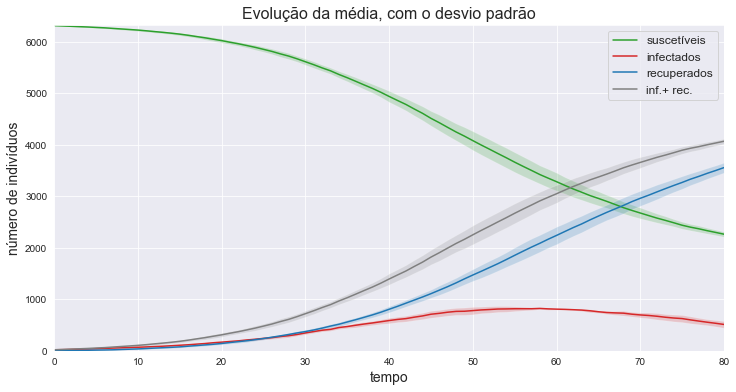

In [31]:
num_sim = 5 # número de simulações
X_g = cenario_rio.evolui_jit(dados_temporais, num_sim, show='sd')

### Comparação

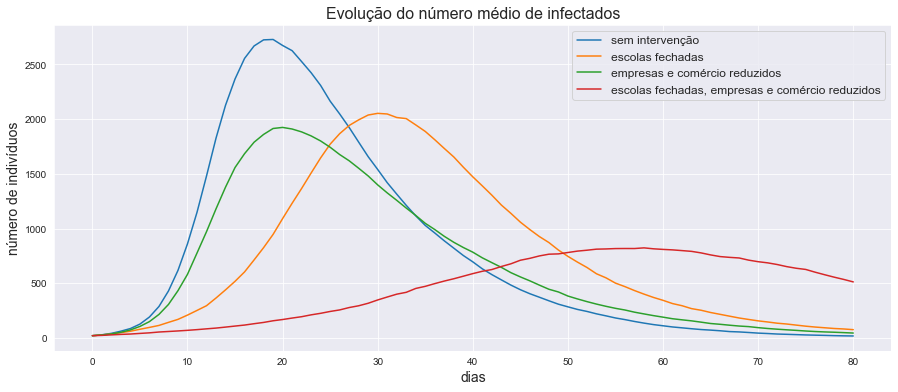

In [32]:
# inicializa a figura
plt.figure(figsize=(15,6))

# traça os gráficos
plt.plot(X.tempos, X.I_medio, label='sem intervenção')
plt.plot(X_esc_0.tempos, X_esc_0.I_medio, label='escolas fechadas')
plt.plot(X_ec.tempos, X_ec.I_medio, label='empresas e comércio reduzidos')
plt.plot(X_g.tempos, X_g.I_medio, label='escolas fechadas, empresas e comércio reduzidos')

# informações para o gráfico
plt.xlabel('dias', fontsize=14)
plt.ylabel('número de indivíduos', fontsize=14)
plt.title('Evolução do número médio de infectados',
          fontsize=16)
plt.legend(loc='best', fontsize=12)

# exibe a figura
plt.show()

<!--NAVIGATOR-->

---
[<- O cenário da cidade do Rio de Janeiro: primeiras simulações](26.00-Cenario_Rio_primeiras_simulacoes.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) 